# LED Display Reflectance and Precision Analysis

Prepared by the Entertainment Technology Center @ USC, based on preparation
and measurements taken in January of 2023.

This document shows the main types of color analysis and error plots published
previously in the [ETC LED Display report, 2023](https://tinyurl.com/ETC2023-LED-report).

For questions please contact [ledeval@doequalsglory.com](mailto:ledeval@doequalsglory.com)


## Basic display measurement

This project includes a script to generate display measurement files. This
process requires two computers, one to run the test pattern generator, and
another to connect to the spectrometer and make measurements. This project
should be installed on the main computer connected to the spectrometer.

The measurement script can be run like the following:

```zsh
python -m colour_workbench.scripts.measure_display --tpg-ip <TPG Computer IP>
```

The `measure_display` script has many configuration options, but in it's basic
form will automatically connect to the TPG computer and spectrometer. After
measuring a series of color patches, which takes about 3 hours, it will output
the display measurements to an automatically generated filename.

You can use the `--help` option to see the full list of options, which mainly
include ways to change the list of sample colors that will be measured.


## PDF generation

A measurement file can be analyzed and turned into a summary PDF by running the
`analyze_display_measurements` script.

```sh
python -m colour_workbench.scripts.analyze_display_measurements <FILE NAME>
```


### Scripted analysis

If you want to run your own analysis or inspect the measurements, open a new
.ipynb or python file and you can use elements of this document as a template.


In [1]:
from specio.fileio import load_measurements
from colour_workbench.ETC.analysis import ColourPrecisionAnalysis

measurements = load_measurements("data/demo_measurements.csmf")

# It's recommended to access the raw measurement data via the
# ColourPrecisionAnalysis. It filters out data that has too low of a signal
# quality to be useful among other things.

data = ColourPrecisionAnalysis(measurements)

/Users/tucker/Dev/colour-workbench/colour_workbench/ETC/analysis.py:88: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(
/Users/tucker/Dev/colour-workbench/submodules/colour-science/colour/utilities/verbose.py:263: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
/Users/tucker/Dev/colour-workbench/submodules/colour-science/colour/utilities/verbose.py:263: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028


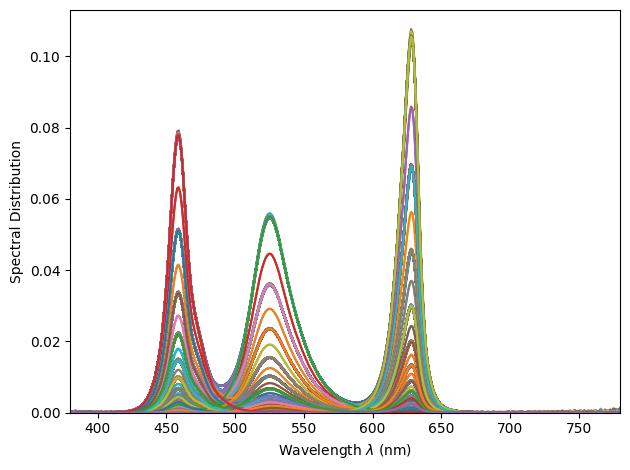

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [2]:
# First we are going to suppress some warnings for this document:

from colour.utilities import suppress_warnings

suppress_warnings(
    python_warnings=True,
    colour_usage_warnings=True,
    colour_runtime_warnings=True,
)

# We can show a plot of all the spectral measurements

from colour.plotting import plot_multi_sds

plot_multi_sds([m.spd for m in data.measurements], legend=False)

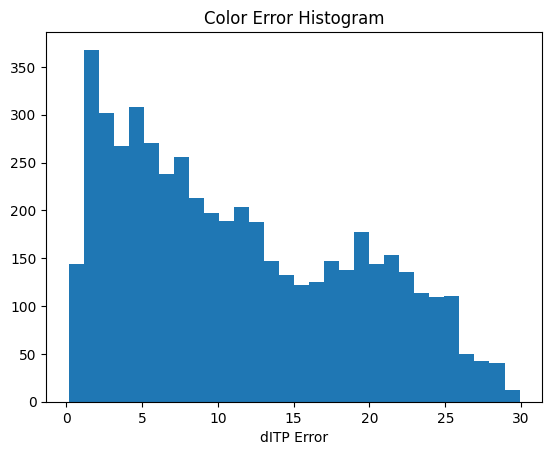

In [3]:
# Another useful plot is showing the histogram of all the dITP errors

import matplotlib.pyplot as plt

plt.hist(data.error["ICtCp"], bins=30)
plt.xlabel("dITP Error")
plt.title("Color Error Histogram")
plt.show()

### Chromaticity Error

The first plot shown in the ETC LED Report PDF is the chromaticity error.

In this plot the MacAdam ellipses are shown along side a series of arrows
denoting the color error in each region of the chromaticity diagram. The arrows
and the ellipses are magnified by 10x, as is typical with MacAdam presentations.
Some researchers, including MacAdam himself, feel that a color error 3-4 times
MacAdam Elapses radius is a "just noticeable difference."

Modern color researchers no longer use this as a JND metric, but it can be a
useful presentation. If the arrows and ellipses are roughly the same size and
orientation that corresponds to an error of 1 MacAdam E. In this plot, the
chromaticity is based on [CIE 1976 u'v'](https://en.wikipedia.org/wiki/CIELUV),
which is significantly more uniform (and superior to) the 1931 chromaticity 
diagram.

It can be generated by the following code:


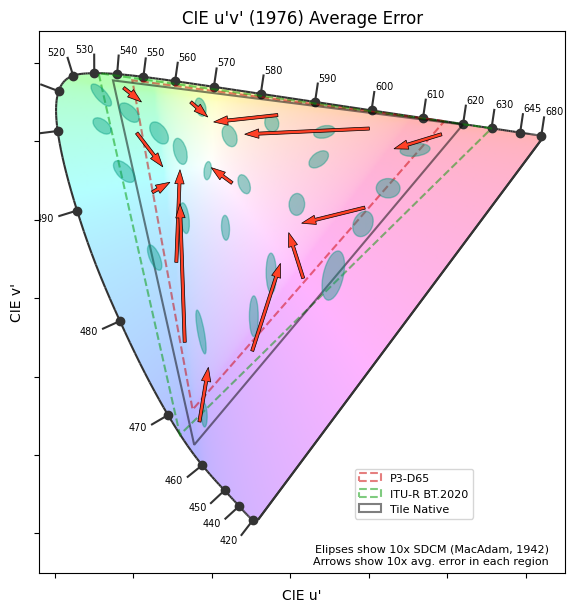

In [4]:
from colour_workbench.ETC.pdf import plot_chromaticity_error

plot_chromaticity_error(data)
plt.show()

### EOTF Tracking

The next plot shows the display system's accuracy in tracking the PQ EOTF.

The purple line shows the display system maximum luminance. Above this value we EXPECT the
display to clip (when metadata and soft-roll off are disabled). The green line
shows a convenient reference point for readers at 1,000 nits.

The X-axis shows 10-bit code values, while the Y axis shows the display
luminance. Luminance is shown in log base-2, which is helpful for understanding
the dynamic range of the display or signal in terms of exposure "stops"


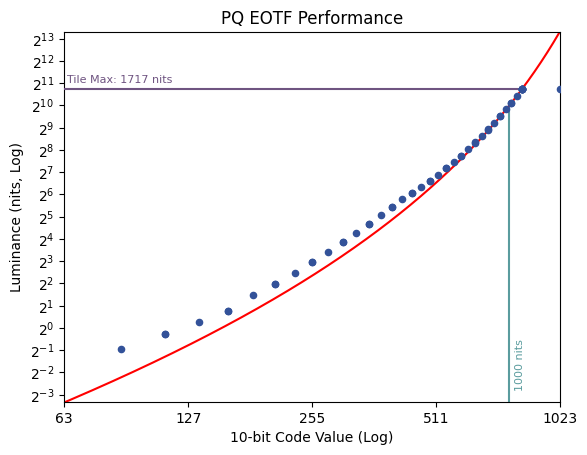

In [5]:
from colour_workbench.ETC.pdf import plot_eotf_accuracy

plot_eotf_accuracy(data)
plt.show()

### White Point Tracking Accuracy

Most video standards specify D65 as the display white point, which means an RGB
value where all three values are the same should produce the chromaticity
(0.1978, 0.3122) in uv or (0.3127, 0.3290) in xy chromaticity.

At lower brightness values some displays will get pinkish or greenish, or their
color temperature will drift towards blue / yellow. In this plot, a red /
yellow / green guide is shown in the background to help educate readers about
noticeable color differences. The guidelines are based on 2 and 4 JND based on
ANSI C78.377

In the top subplot, the color temperature error is based on the tile maintaining a
color temperature equivalent to D65, 6504K. The lower subplot is based on
maintaining the same pink / green offset (also known as ∆uv)


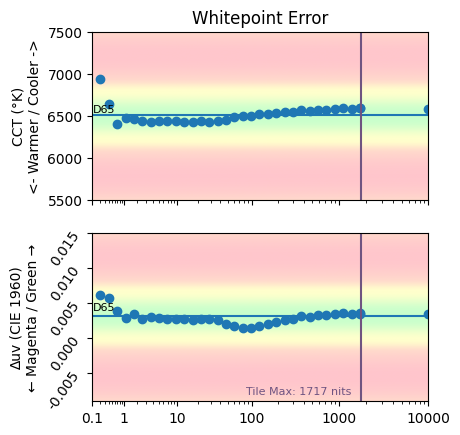

In [6]:
from colour_workbench.ETC.pdf import plot_wp_accuracy

plot_wp_accuracy(data)
plt.show()

### Brightness Error

The next plot in our analysis shows the brightness error scaled to the dITP
color difference model. Finally, for the particular measurements contained in
this file, this plot finally shows us some interesting performance
characteristic.

In this plot the red / yellow / green guide roughly shows 1, 4, and 8 JND. These
values are scaled from the dITP color difference metric. It's important to keep
in mind that there isn't a single value of acceptance when it comes to color
difference metrics. In many real image viewing scenarios, a ∆I of 5-6 may not be
noticeable. In other scenarios, a difference of 2-3 is obvious.

If all of the measurements shown on this plot are in the green - yellow region,
it's indicates reasonable performance for most scenarios. The y-axis is shown in
logarithmic scale, once measurements are shown in the red-zone it's very likely
that they are creating noticeable distortions in the tone scale of the image.

The shape or trend of this error may help indicate what types of 1D or 3D LUTs
can correct this error. Errors tending towards the top of the plot are showing
that the measured color is brighter than the intended color, and towards the
bottom, the measured color is darker than the intended color.


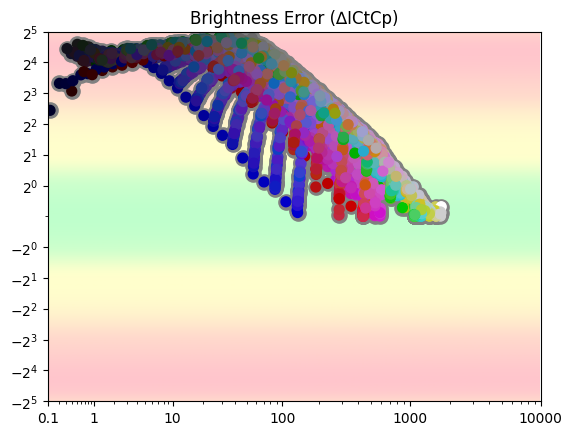

In [7]:
from colour_workbench.ETC.pdf import plot_brightness_errors

plot_brightness_errors(data)
plt.show()

### Chroma Error

The last plot on the analysis report shows the chroma error, in this plot the
brightness error has been removed and only the error in hue and saturation is
included. Chroma is scaled to be more relevant to perception.

Due to the nature of chroma measurement, this plot does not show positive and
negative error. Only the total amount of error. Chroma is analogous to hue and
saturation combined.

In this example data, the LED display system has a wide range of chroma errors and little
relationship between the hues. It's likely that this LED display system is not configured
in the correct gamut.


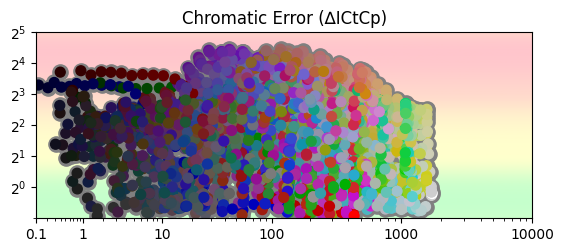

In [8]:
from colour_workbench.ETC.pdf import plot_chromatic_error

plot_chromatic_error(data)
plt.show()

### Color Error Statistics

The last information shown on the analysis document is the image statistics.
They can be shown in-code or in a python notebook (like this document) with the
code below.

The three color error statistics are ∆XYZ, ∆dITP, and ∆dE2000. ∆XYZ is not a
perceptual color difference metric but shows the total physical error and is
sometimes helpful for colour-engineers to debug other color algorithms.

dITP is a perceptual color difference metric proposed by Dolby and standardized
by ITU in BT-2124. ITP is an extremely sensitive color metric which under the
most extreme and ideal circumstances shows 1 JND. But for moving or complex
imagery, the noticeable difference threshold is higher.

The mean dITP error correlates to the average display performance across the
entire color volume, while the 95th percentile correlates more with the maximum
error.

dE2000 is similar to dITP in that it is a perceptual color difference metric,
but it is less sensitive than dITP and makes some assumptions about the viewing
conditions. For normal complexity or moving imagery, typical observers are less
sensitive to minute color differences. These minute color differences at low
brightness are not usually perceptible for normal observers and conditions, but
are included in and can inflate dITP error.

Between both dITP and dE2000, one is not better than the other. ITP can be
useful for understanding physical error in a logarithmic scale, which is
important for understanding the dynamic range or maximum / minimum exposure
range a display is capable of reproducing. Whereas dE2000 is better at
understanding how a human observer checking over the display imagery might
perceive it.


In [9]:
print(data)


Error Data for e5854aee
    Mean dXYZ:    20.41    95% <  33.41
    Mean dITP:    11.35    95% <  24.97
    Mean dE2000:   3.71    95% <   9.92



### Reflectance data

The LED reports published by the Entertainment Technology Center Virtual
Production Working Group in January include reflectance characteristics for the
LED tiles which must me measured seperately than automated display measurements.

Reflectance is an important display characteristic because it determines the
black level of an LED display. In a color measurement lab, the the dynamic range
of a display can be measured to approach infinity. Dynamic range is the ratio of
the brightest a display area can be divided by the darkest a display can be. In
a lab with no ambient light, the LEDs can reach complete black where they don't
emit any light. Meaning that the dynamic range of a 1500 nit LED tile, is
1500/0.

Instead, in actual usage scenarios the black level of a display is determined by
how much of the ambient light is being reflected by the display. Reflectance is
measured in particular geometries and depends on the angle of the light source
and the angle of the camera or observer. Reflectance measurements are normally
denoted in the following pattern _influx angle_:_measurement angle_ where 0° is
tne normal angle perpendicular to the display. This convention comes from the
color and radiance metrology industry.

For example, the 45:-45 reflectance measurement means that the light source was
placed at 45 degrees from the measurement surface and the camera / spectrometer
was placed at -45 degrees, or the mirror angle of the light source. This is a
measurement that includes the glossiness of the object.

The 45:0 measurement means that the light source was placed at 45 degrees from
the measurement surface, and the spectrometer was placed at 0 degrees or
perfectly perpendicular from the surface.

For the LED evaluation reports, the ratio of 45:-45 reflectance over 45:0 is
denoted the "glossiness" where a lower score means the LED tile is less glossy.

In practice and in scientific use, glossiness and reflection is very complicated
to evaluate.


In [10]:
from colour_workbench.ETC.analysis import ReflectanceData

r_data = ReflectanceData(reflectance_45_0=0.034, reflectance_45_45=0.058)
print(r_data)


Reflectance Data:
    45:-45 (specular) -> 5.80%
    45:0    (matte)   -> 3.40%
    Glossiness Ratio  -> 1.7



## Example Data Use Cases

### Estimating contrast ratio for a specific environment

As described in the section [Reflectance Data](#reflectance-data), an LED
display's contrast ratio is determined by the ambient illuminance falling onto
the surface of the display and the reflectance of the display. If the ambient
illuminance falling on the display is 35 lux, the reflected luminance of the
display will be

$$
\begin{equation} \tag{Eq. 1}
    Rl = \frac{Rf * 35lux}{\pi}
\end{equation}
$$

where $Rf$ is the reflectance factor of
the geometry being considered and $Rl$ denotes the reflected luminance.

For this estimate we will assume the 45:0 geometry is representative of the
non-specular reflectance performance of the LED display.

For our example data above:

$$
\begin{align}
    Rl &= \frac{3.4\% * 35lux}{\pi} \nonumber \\ \nonumber \\
       &= 0.3788nits \nonumber
\end{align}
$$

This is an estimate of the darkest black level that this particular LED display
will achieve in an environment with 35 ambient lux illuminating the display. For
a 1500 nit display, the maximum contrast ration can be calculated using
$Eq. 2$ were $M$ is the maximum display luminance and $Cr$ is the contrast
ratio.

$$
\begin{align} \tag{Eq. 2}
    Cr &= \frac{M + Rl}{Rl} \nonumber \\ \nonumber \\
       &= \frac{1500 + 0.3788}{0.3788} \nonumber \\ \nonumber \\
       &\approx 3961:1 \nonumber
\end{align}
$$

Using these same equations and estimating for 150lux of ambient spill, which I
recently measured on one broadcast set, the maximum contrast ratio of a 1500 nit
display can be estimated to be 925:1.

The most significant improvement that can be made to improve the contrast ratio
or dynamic range of a display is to improve the ambient spill on the display and
secondly to reduce the reflectance of the display.

In the real world, this estimate is wrong depending on the exact geometry of the
lighting and the fully characterized bi-directional reflectance distribution
function (BDRF), but for our purposes of simply evaluate baseline performance,
this estimate can inform us which of two displays will have a higher contrast
ratio.

### A note about glossiness

In an effort to improve the contrast ratio of a display and maximize the
achievable dynamic range, some manufacturers will apply a glossy coating to the
LED display. This glossy coating helps improve contrast ratio by redirecting the
light that would normally be diffusely reflected towards the camera, and instead
reflecting that light in the specular direction. As long as you do not film or
observe the display from those specular directions, a glossy coating can GREATLY
improve the dynamic range.

One glossy display that was evaluated by the ETC VPWG in January 2023 had a 45:0
reflectance of 0.8%. At 35 lux ambient this implies a contrast ratio of 16830:1,
or 14.04 stops of dynamic range. At 150 lux this equates to a contrast ratio of
3928:1 or 11.94 stops.

However, because of the optics and tradeoffs of the glossy reflection, any
lights that are specular reflected towards the observer will be immediately
obvious and a great detriment to the contrast ratio. That particular tile had a
45:-45 reflection factor of 165.7%.

For reference, a matte piece of paper or a diffuse reflectance standard such as
fluorilon reflect nearly 100% of the incoming illuminance from 45 degrees in all
directions. A glossy surface concentrates this reflectance towards the specular 
direction, lowering the reflectance everywhere else, and increasing the 
reflectance in that particular direction. Lux measurements and light meters are 
integrating light over a diffuse area, and thus we consider the diffuse 
measurement to be the reference at 100%

In this scenario, the specular contrast ratio is 82:1 or 6.3 stops at 35 lux
and 20:1 or 4.31 stops at 150 lux. 

These calculations are implemented in the code below.

In [11]:
from textwrap import dedent
import numpy as np

max_tile_luminance = 1500
reflectance_factor = 166.7 / 100 # Convert from % to a scaler value

Rl_35 = 35 * reflectance_factor / np.pi # Equation 1
Cr_35 = (max_tile_luminance + Rl_35) / Rl_35

Rl_150 = 150 * reflectance_factor / np.pi # Equation 2
Cr_150 = (max_tile_luminance + Rl_150) / Rl_150

#fmt: off
print(
    dedent(
        f"""
        Tile Luminance: {max_tile_luminance:8.1f}, Reflectance Factor: {reflectance_factor * 100:.1f}%
            35 Lux:
                CR: {Cr_35:8.0f}:1  Stops: {np.log2(Cr_35):5,.2f}
            1500 Lux:
                CR: {Cr_150:8.0f}:1  Stops: {np.log2(Cr_150):5,.2f}
        """
    )
)
#fmt: on


Tile Luminance:   1500.0, Reflectance Factor: 166.7%
    35 Lux:
        CR:       82:1  Stops:  6.35
    1500 Lux:
        CR:       20:1  Stops:  4.31



## ETC Analysis and Measurement Methodology

For detailed questions about the methodology implemented in this project, please
contact [ledeval@doequalsglory.com](mailto:ledeval@doequalsglory.com).

This is not a complete description of the methodology used, but should provide
some helpful notes regarding the circumstances of making these measurements and
how he colorimetric analysis is done. This section is meant for engineers and
scientists who are reviewing, re-implementing, or using this github project to
repeat measurements in their own labs and companies. 

### Display System Configuration

This analysis and the provided scripts, python code, and examples assume that
the display system is configured in manual override for PQ and native gamut.
This analysis is based on measuring the *precision* of a display's native and
maximum performance. This project does not measure the *accuracy* of a display's
adherence to other standards such as Rec.709 or Rec.2100. 

If a display passes performs well in these analysis, then electrically it is
capable of implementing complex and well controlled gamut transforms. Many end
users will implement color management of an LED display system for ICVFX in the
upstream or content side of their system. Others will configure their image
generation system to output a standard format such as Rec.709 and then implement
a gamut transform in the display processor by configuring the processor to the
same color space. 

In this latter scenario, the LED or display processor is transforming the
incoming rec.709 data into some other color values based on the native
performance of the display. Where the native gamut and target gamut overlap,
presumably the true measurable output will be correct. Where the native gamut
does not contain the rec.709 gamut, the display will have to clip or implement
some other gamut mapping algorithm to shift the input rec.709 color to a
in-gamut native color. For typical large format, modular, LED Displays this
frequently happens for the blue primary.

The gamut mapping strategies of various display processors is not always
transparent, or clipping behavior may not be considered correct by the end user.
It is not the position of the ETC VPWG to recommend a specific strategy at this
time. Therefore this analysis does not attempt to analyze these display modes.
But a processing system and LED tile that performs *precise* color operations,
should have the maximum power and accuracy in implementing these transforms and
gamut mapping strategies. 

### Test pattern generation

A programmable test pattern generator to send specific color patch values is
very important for automating hundreds or thousands of color measurement to
evaluate a display. Unfortunately, simple api controllable test pattern 
generators are not yet available or are prohibitively expensive hardware.

For this project, the testers implemented their own test pattern generator
contained in the github repository [ETC Test
Patterns](https://github.com/tjdcs/ETC_TestPatterns). Normally, including now,
you should be very skeptical of software based TPGs from unknown implementers on
unknown hardware. In many cases, operating system color management, game engine
shaders, display drivers, intermediate video switching equipment, or other
factors can transform your test color values to other unintended colors. This
will in-turn distort the results of your color test. 

In the case of the ETC sponsored testing in January 2023, the test pattern
generator above was validated by bi-directionally inspecting the values in the
graphics card memory output buffer and inspecting the input buffer values on a
high quality AV system. Maybe that is enough to convince you to use this test
pattern generator and project, but you should probably try to do the same
validation if you can. 

### Native gamut estimation

The native color gamut and transformation matrix, sometimes called the
normalized primary matrix, must be calculated based on measurements. One simple
way to estimate the primary matrix is to pick a particular greyscale value, such
as 255 or 128, and measure each primary and the white point at this value.
However, this method assumes that the gamut performance of the display,
linearity, and channel independence is uniform for all input values. This is
rarely the case. 

Instead, the chromaticity of each LED channel and the white point, is estimated 
by calculating the robust minimum covariance matrix and fitting an elliptic 
envelope to the measurement data of each primary. This mathematical process
assumes that the true value of the display primary is obscured by random errors
and noise in the measurement process. These errors are assumed to produce a
gaussian distribution centered around the true value. A multivariate gaussian
envelope, or ellipse, is centered on this data with an attempt to exclude
outliers. The center of this ellipse is assumed to be the true value of the
display primary. This implementation is located
[here](https://github.com/tjdcs/colour-workbench/blob/38b6c7c90216eabf45c913dd38748b1704c08ec4/colour_workbench/ETC/analysis.py#L197).

A third method to estimate the true NPM is to apply an optimization algorithm
to the first estimate, minimizing ∆XYZ. However, this is not implemented in this
project, as it makes additional assumptions about the meaning of the npm matrix
and acceptable display performance that may not apply to all users. 

### Assumptions about dE2000

Using dE2000 to evaluate display performance requires some assumptions about the
environment and type of content that will be shown on the display. Namely these
two assumptions include that the display whitepoint is being analyzed close to
D65, otherwise first a chromatic adaptation transform must be applied to the
measurement data. Secondly, we must decide what the "normal" or adaptation
luminance should be. In this analysis we assume that the end user HDR content is
rendered for a diffuse white point and adaptation condition (20% grey) of 31.8
nits. This is typical of reasonable indoor or office viewing conditions, but 
for cinema viewing conditions a lower adaptation point is required. 

The adaptation assumptions are set
[here](https://github.com/tjdcs/colour-workbench/blob/38b6c7c90216eabf45c913dd38748b1704c08ec4/colour_workbench/ETC/analysis.py#L495C26-L495C26)
and are not changeable by the provided analysis scripts at this time.  


## Thank you!

Thank you for your time and care in reading this document!